# Predicting Heart Disease

![internal_structures_1_0.jpg](internal_structures_1_0.jpg)

# Table of Contents

1. [**Introduction**](#1)
2. [**Load the Data**](#2)
3. [**Exploratory Data Analysis**](#3)
4. [**Data Cleaning**](4#)
5. [**Feature Selection**](#5)
6. [**Single-Feature Classifier**](#6)
7. [**Multi-Feature Classifier**](#7)
8. [**Hyperparameter Tuning**](#8)
9. [**Model Evaluation**](#9)
10. [**Conclusion**](#10)

<a id="1"></a>
# Introduction
The World Health Organization(WHO) estimates that 17.4 million people die from cardiovascular diseases(CVDs) every year. There are multiple risk factors that could contribute to CVD in an individual, such as unhealthy diet, lack of physical activity, or mental illness. Identifying these risk factors early on could help prevent many premature deaths. 

**Project Goal:**
In this project, we will use the [Kaggle dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) and build a K-Nearest Neighbors classifier to accurately predict the likelihood of a patient having a heart disease in the future.

<a id="2"></a>
# Load the Data
The dataset has the following features:
* `Age`: age of the patient[years]
* `Sex`: sex of the patient [M: Male, F: Female]
* `ChestPainType`: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* `RestingBP`: resting blood pressure [mm Hg]
* `Cholesterol`: serum cholesterol [mm/dl]
* `FastingBS`: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* `RestingECG`: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* `MaxHR`: maximum heart rate achieved [Numeric value between 60 and 202]
* `ExerciseAngina`: exercise-induced angina [Y: Yes, N: No]
* `Oldpeak`: oldpeak = ST [Numeric value measured in depression]
* `ST_Slope`: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* `HeartDisease`: output class [1: heart disease, 0: Normal]

In [1]:
# import libraries
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<a id="3"></a>
# Exploratory Data Analysis
We will start with exploring our dataset.

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


The dataset seems to contain both numerical and categorical features. Let's look at the datatype for each column.

In [3]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [4]:
df.dtypes.value_counts()

int64      6
object     5
float64    1
dtype: int64

`7` features in total are numerical while `5` are categorical. However, two of the numerical features, `FastingBS` and `HeartDisease` are categorical as well. 
We will focus on the numerical variables first.

In [5]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


**Insights**
* The average age of patients is ~`53` years.
* The median for `Cholesterol` is higher than its mean by roughly `25mm/dl`, indicating that it could be a left-skewed distribution with a possibility of outliers skewing the distribution.
* `RestingBP` and `Cholesterol` have a minimum value of `0`.
* There doesn't seem to be any missing values in these columns.

`RestingBP` can't be `0`. And, as per the [American Heart Association](https://www.heart.org/en/health-topics/cholesterol/about-cholesterol/what-your-cholesterol-levels-mean), serum cholesterol is a composite of different measurements. So, it is unlikely that `Cholesterol` would be `0` as well. We will have to clean both of these up later. 

Next, we will look at the categorical variables. It would also be beneficial to look at how the target feature, `HeartDisease`, is related to those categories. Before that, let's check if there are any missing values in the dataset or not.

In [6]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

There are no missing values in the dataset!
Let's now look at the categorical columns from our dataset. We identified that most of the categorical columns are all of dtype `object`. We can summarize the columns as follows:

In [7]:
df.describe(include=['object'])

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


We can confirm that the columns above are indeed categorical given the number of unique values in each of them. But, we can't gather much else. `FastingBS` and `HeartDisease` are categorical as well since they only contain binary values. 

In [8]:
df["FastingBS"].unique(), df["HeartDisease"].unique() 

(array([0, 1]), array([0, 1]))

In [9]:
df["HeartDisease"].value_counts()


1    508
0    410
Name: HeartDisease, dtype: int64

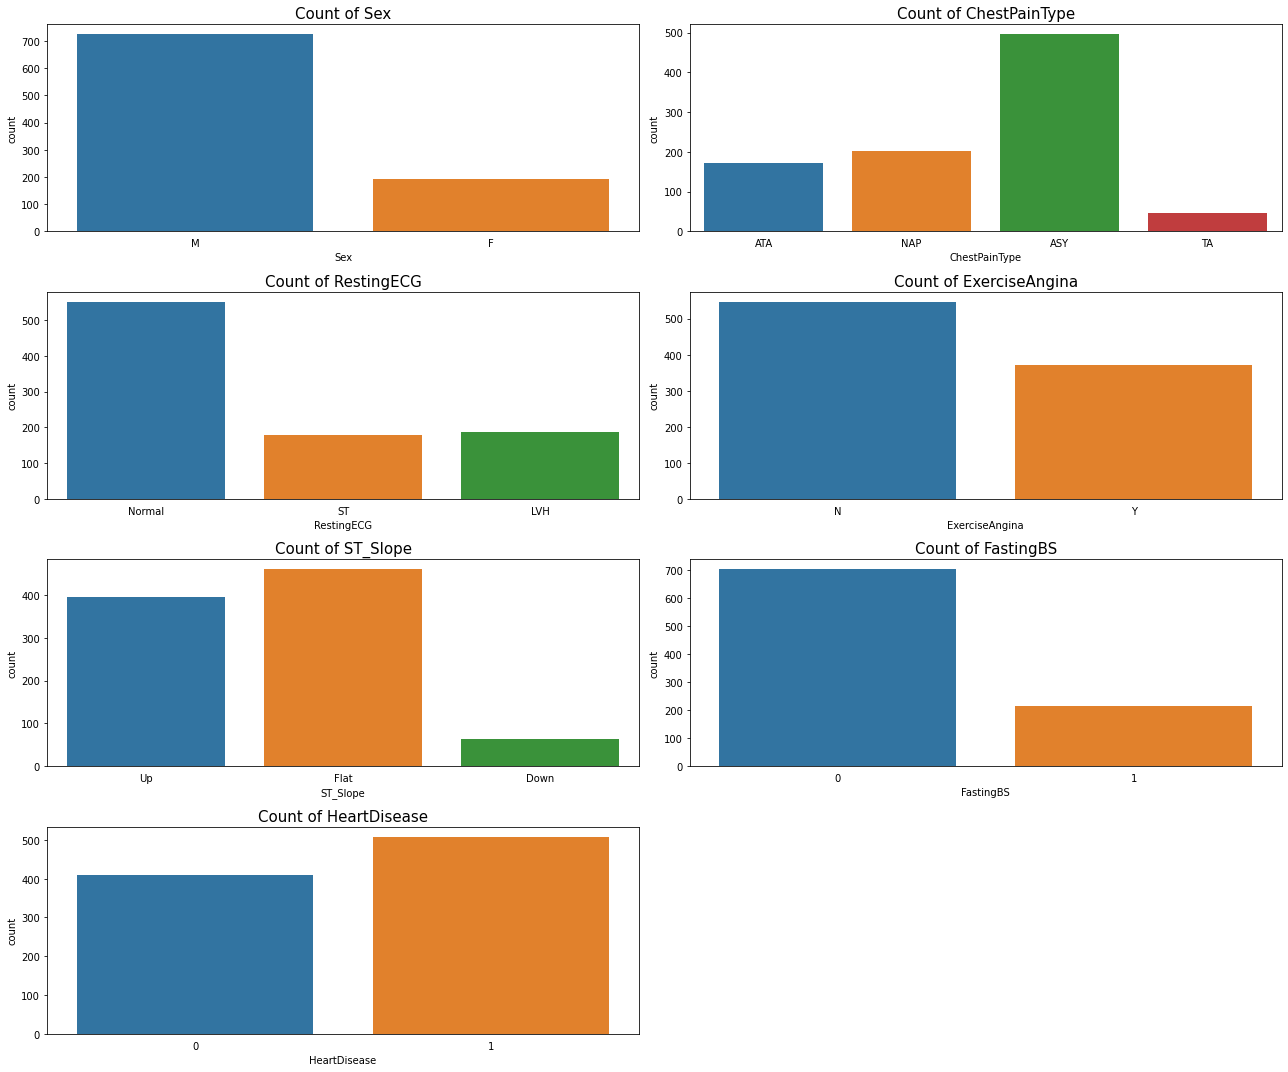

In [10]:
categorical = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS', 'HeartDisease']
fig = plt.figure(figsize=(18,15))

for idx, col in enumerate(categorical):
    ax = plt.subplot(4, 2, idx+1)
    sns.countplot(x=df[col], ax=ax)
    # remove the ticks
    ax.tick_params(bottom=False)
    ax.set_title(f'Count of {col}', size=15)
fig.tight_layout() 
plt.show()

**Insights**
* The dataset is highly skewed towards the male patients. There are `725` male patients and `193` female patients. This could potentially introduce a bias in our model.
* `496` patients had `ASY`(asymptotic) chest pain type.
* `552` patients had a `Normal` resting ECG.
* `704` patients had blood sugar lower than `120mg/dl`

Let's now group the different categores by `HeartDisease` to get a better idea about the data distribution.

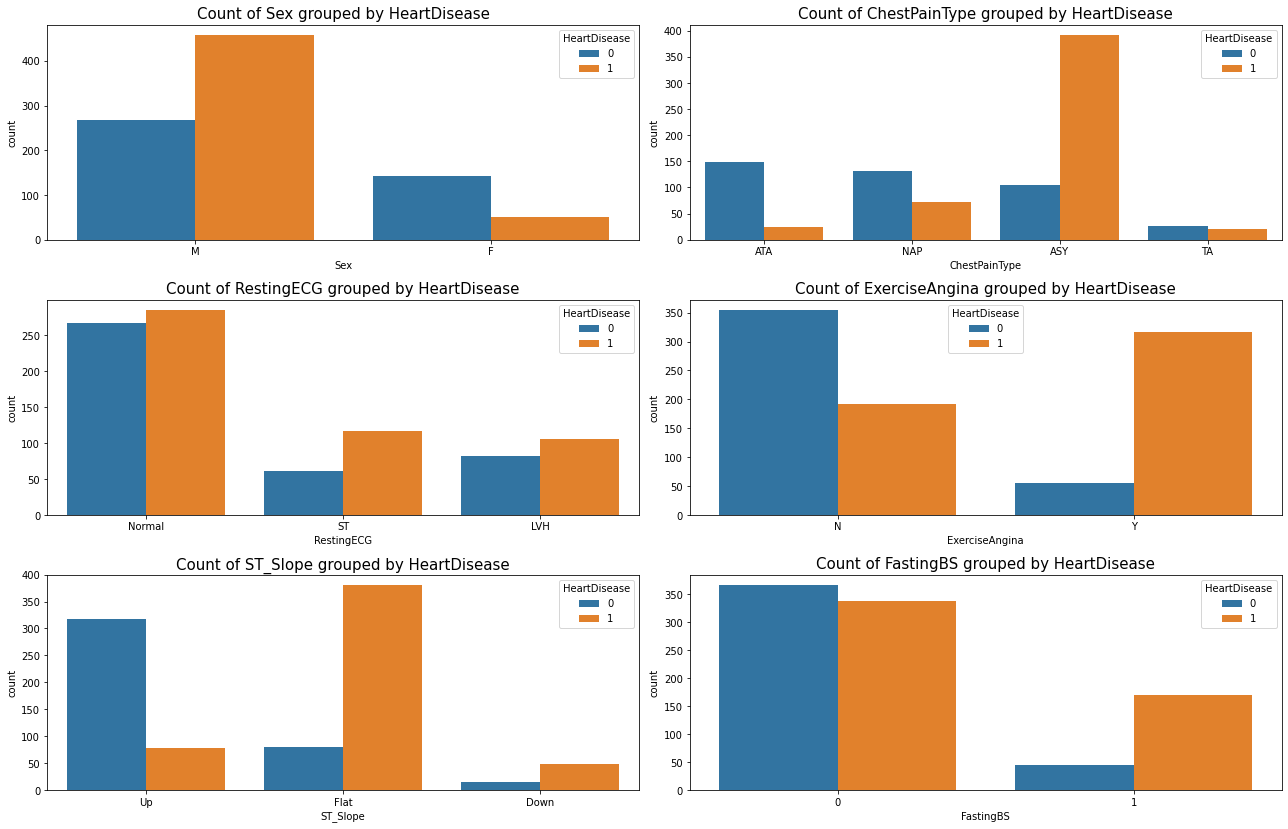

In [11]:
fig = plt.figure(figsize=(18,15))

for idx, col in enumerate(categorical[:-1]):
    ax = plt.subplot(4, 2, idx+1)
    # group by HeartDisease
    sns.countplot(x=df[col], hue=df['HeartDisease'], ax=ax)
    ax.set_title(f'Count of {col} grouped by HeartDisease', size=15)
fig.tight_layout() 
plt.show()

**Insights**
* We can further notice how skewed the dataset is towards male patients. Only `50` female patients in the dataset have been diagnosed with heart disease.
* A significant number of patients, `392`, diagnosed with heart disease have asymptomatic(ASY) chest pain. While chest pain could be a relevant feature for our model, asymptomatic implies that those patients who had a heart disease did not have chest pain as a symptom.
* A high number, `170`, of patients with blood sugar greater than 120 mg/dl were diagnosed with heart disease in relation to those who were not diagnosed as such. 
* Out of all patients who had an exercise-induced angina, `316` were diagnosed with a heart disease. 
* Out of all patients with a flat ST slope, `318` were diagnosed with a heart disease. 

Looking at the data distribution from the above plots, we can start to identify some features that could be relevant to us. We will clean up the dataset a bit first before narrowing down on our features. 

According to [National Institute on Aging](https://www.nia.nih.gov/health/heart-health-and-aging):
> People age 65 and older are much more likely than younger people to suffer a heart attack, to have a stroke, or to develop coronary heart disease (commonly called heart disease) and heart failure.

To further explore our data, let's look at the percentage of male patients with heart disease and over 55 years old.

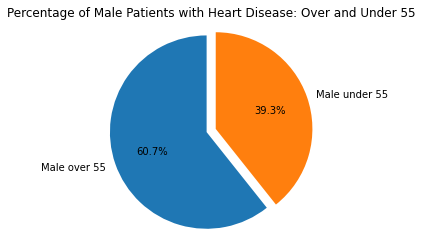

In [12]:
heart_df =  df[(df['HeartDisease'] == 1) & (df['Sex'] == 'M')]
male_over_55 = (heart_df['Age'] >= 55).sum()
perc_male_over_55 = male_over_55 / len(heart_df) * 100

# Create pie chart
labels = ['Male over 55', 'Male under 55']
sizes = [perc_male_over_55, 100 - perc_male_over_55]
explode = (0.1, 0)

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
ax.set_title('Percentage of Male Patients with Heart Disease: Over and Under 55')

plt.show()

Approximately `61%` of the male patients with heart disease are over 55 years old. This shows there is a higher risk of developing heart disease in males over 55 years old. 

We'll now look at the median age of patients with heart disease and compare this age in the male and female patients. 

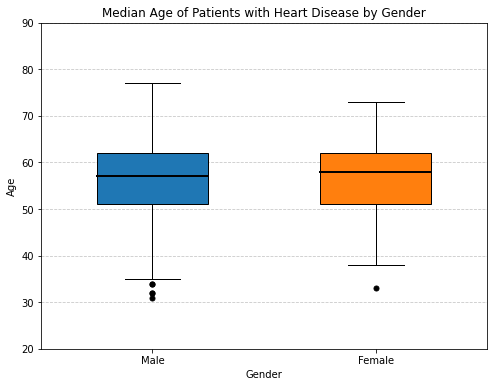

In [13]:
heart_df =  df[df['HeartDisease'] == 1]
plt.figure(figsize=(8, 6))

# Create box plot
ax = plt.boxplot(x=[heart_df[heart_df['Sex'] == 'M']['Age'], heart_df[heart_df['Sex'] == 'F']['Age']],
                 labels=['Male', 'Female'], patch_artist=True, widths=0.5, showfliers=True,
                 flierprops={'marker':'o', 'markerfacecolor':'black', 'markersize':5})

# Set boxplot colors
colors = ['#1f77b4', '#ff7f0e']
for patch, color in zip(ax['boxes'], colors):
    patch.set_facecolor(color)

# Set median line color
for median in ax['medians']:
    median.set(color='black', linewidth=2)

# Set axis labels and title
plt.xlabel('Gender')
plt.ylabel('Age')
plt.title("Median Age of Patients with Heart Disease by Gender")

# Set y-axis range
plt.ylim(20, 90)

# Add horizontal grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

From the graph above, the median age for `female` patients with heart disease is `58`, on the other hand, the median age for the `male` patients with heart disease is `57`. This is a slight difference and therefore important to not that gender is not the only factor that could influence development of heart disease. 

<a id="4"></a>
# Data Cleaning
We identified that there are no missing values in the dataset. However, as we noticed earlier, a couple of columns have 0 values which don't make sense. 

We will look at how many zero values `RestingBP` and `Cholesterol` contain and decide how to handle those. 

In [14]:
df[df['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [15]:
df[df['Cholesterol'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


* `RestingBP` has only one zero value. We can remove that row from consideration. 
* There are `172` zero values for `Cholesterol`. That is a relatively high number. We can't remove them all, so we will replace the values with the median. We will replace the zero values in `Cholesterol` in relation to `HeartDisease`. So, the 0 values in `Cholesterol` for patients who were diagnosed with heart disease will be replaced by the median of the non-zero values for patients who were diagnosed with a heart disease. And we will do the same for those who were not diagnosed with a heart disease.

In [16]:
df_clean = df.copy()

# only keep non-zero values for RestingBP
df_clean = df_clean[df_clean['RestingBP'] != 0]

heartdisease_mask = df_clean['HeartDisease'] == 0
cholesterol_without_heartdisease = df_clean.loc[heartdisease_mask, 'Cholesterol']
cholesterol_with_heartdisease = df_clean.loc[~heartdisease_mask, 'Cholesterol']

df_clean.loc[heartdisease_mask, "Cholesterol"] = cholesterol_without_heartdisease.replace(to_replace = 0, value = cholesterol_without_heartdisease.median())
df_clean.loc[~heartdisease_mask, "Cholesterol"] = cholesterol_with_heartdisease.replace(to_replace = 0, value = cholesterol_with_heartdisease.median())

In [17]:
df_clean[['Cholesterol', 'RestingBP']].describe()

,Cholesterol,RestingBP
count,917.000000,917.000000
mean,239.700109,132.540894
std,54.352727,17.999749
min,85.000000,80.000000
25%,214.000000,120.000000
50%,225.000000,130.000000
75%,267.000000,140.000000
max,603.000000,200.000000


The minimum values for both columns have changed and we no longer have any zeros. 

<a id="5"></a>
# Feature Selection
From the EDA we have performed above, we have a general understanding of our features and therefore are able to identify some of the features we could start with:
* `Age`
* `Sex`
* `ChestPainType`
* `Cholesterol`
* `FastingBS`

We will also identify how strongly the feature columns are correlated with the target column. This will help us narrow down on the features. In order to do that, let's first convert our categorical columns into dummy variables. 


In [18]:
df_clean = pd.get_dummies(df_clean, drop_first=True)
df_clean.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


Now, we can find how they are correlated. 

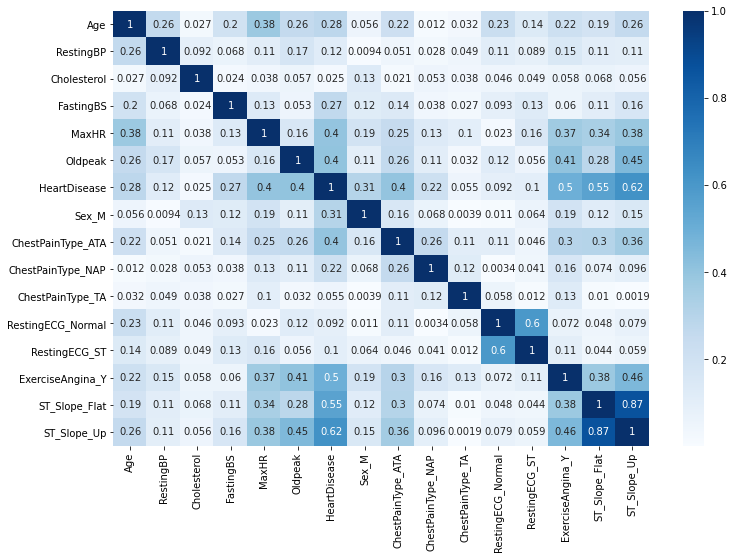

In [19]:
correlations = abs(df_clean.corr())
plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True, cmap='Blues')
plt.show()

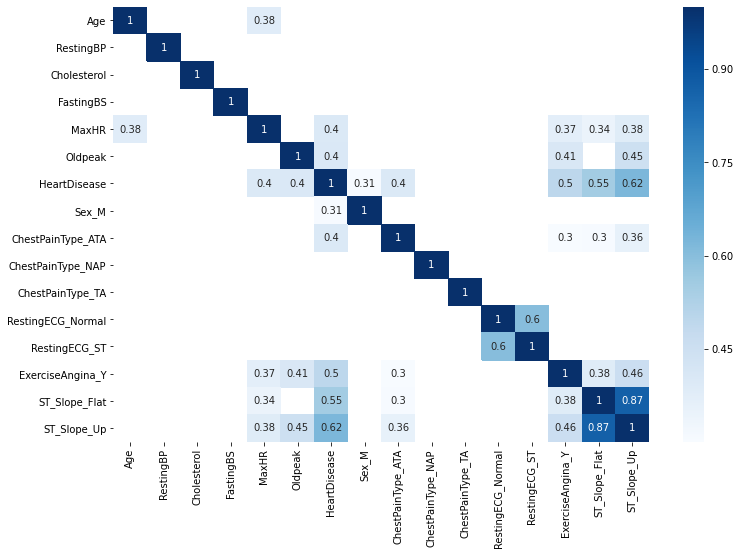

In [20]:
plt.figure(figsize=(12,8))
sns.heatmap(correlations[correlations > 0.3], annot=True, cmap='Blues')
plt.show()

From our correlation heatmap, we can identify that the following features are positively correlated(with coefficient > 0.3) to `HeartDisease`. 
* `Oldpeak`
* `MaxHR`
* `ChestPainType_ATA`
* `ExerciseAngina_Y`
* `ST_Slope_Flat`
* `ST_Slope_UP`

Surprisingly, `Cholesterol` is not strongly correlated to `HeartDisease`. We can consider ignoring the feature for now. 

Given everything we have attempted so far, we can narrow down our features to the following:
* `Oldpeak`
* `Sex_M` - it has a relatively low value for the coefficient, but given what we observed in our EDA, let's take it into account. 
* `ExcerciseAngina_Y`
* `ST_Slope_Flat`
* `ST_Slope_Up`

We can now create our model using these features. 

<a id="6"></a>
# Single-Feature Classifier
We will begin by creating a separate model for each of the features that we have selected and evaluate their performance using accuracy as a metric. To determine the optimal split percentage, we will experiment with different values of `test_size`. Let's first split our dataset to training and validation sets:

In [21]:
X = df_clean.drop(['HeartDisease'], axis=1)
y = df_clean['HeartDisease']

features = [
    'Oldpeak',
    'Sex_M',
    'ExerciseAngina_Y',
    'ST_Slope_Flat',
    'ST_Slope_Up'
]

# test sizes to experiment with
test_sizes = [0.1, 0.15, 0.2, 0.25]
results = {}

for test_size in test_sizes:
    X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                     test_size=test_size,
                                                     random_state=417)
    test_results = {}
    # fit knn with the different features
    for feature in features:
        knn = KNeighborsClassifier(n_neighbors = 3)
        knn.fit(X_train[[feature]], y_train)
        accuracy = knn.score(X_val[[feature]], y_val)
        test_results[feature] = round(accuracy, 3) * 100
        
    results[test_size] = test_results

# create dataframe to view our results
test_size_df = pd.DataFrame(results)
test_size_df


,0.10,0.15,0.20,0.25
Oldpeak,78.3,71.0,70.1,73.5
Sex_M,56.5,61.6,65.8,67.0
ExerciseAngina_Y,71.7,55.1,71.2,45.7
ST_Slope_Flat,53.3,55.1,56.0,54.3
ST_Slope_Up,84.8,84.1,81.0,45.7


From the results above, we can see that the different features yield different accuracy values. The optimal test_size, on the other hand, depends on the selected feature. 

Based on the given results, a test size of `0.1` or `0.15` may be a good choice to balance the trade off between variance and bias. 

We will proceed with a test size of `0.15` for our next steps. Let us now explore how the different values of `n-neighbors` impact our model's accuracy. 

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                 test_size = 0.15,
                                                 random_state = 417)
neighbors = [1, 3, 5, 7, 10]
results = {}
for n in neighbors:
    test_results = {}
    for feature in features:
        knn = KNeighborsClassifier(n_neighbors=n)
        knn.fit(X_train[[feature]], y_train)
        accuracy = knn.score(X_val[[feature]], y_val)
        
        test_results[feature] = round(accuracy, 3) * 100
    results[n] = test_results
    
neighbors_df = pd.DataFrame(results)
neighbors_df

,1,3,5,7,10
Oldpeak,70.3,71.0,71.7,76.8,75.4
Sex_M,44.9,61.6,61.6,61.6,61.6
ExerciseAngina_Y,55.1,55.1,55.1,55.1,73.2
ST_Slope_Flat,55.1,55.1,81.9,81.9,81.9
ST_Slope_Up,84.1,84.1,84.1,84.1,84.1


Based on our experiments, we have found that the accuracy of the k-Nearest Neighbors model varies with different values of `n_neighbors`. However, the improvement in accuracy is not significant for some values of n_neighbors. Therefore, we will use `k=5`, for n_neighbors.

As we can see from the table, the accuracy scores for some values of n_neighbors are similar, indicating that increasing n_neighbors does not improve the model's performance significantly.

Using `k=5`, the best performing model, with an accuracy of `~84%`, was trained on the `ST_Slope_Up` feature with `ST_Slope_Flat` being a close second. 

We will now train a model using all the features:

<a id="7"></a>
# Multi-Feature Classifier
Let's combine all the features and train a model on them to see if we can achieve a higher accuracy than what we have so far. Before doing this, we will need to normalize or data because our features are not within the same range. We will scale our selected features to the range(0, 1) before training our model.

In [23]:
# scale our features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])

# train the model using the scaled features
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
accuracy = knn.score(X_val_scaled, y_val)
print(f'Accuracy: {accuracy*100:.2f}')

Accuracy: 86.23


The model's accuracy has moved to `~86%`. This is a good start. Using all the features results in an improved model, but let's see what parameters/hyperparameters might be optimal.

<a id="8"></a>
# Hyperparameter Tuning
We will use `GridSearchCV` which allows us to search over all the parameters for our classifier in scikit-learn. We will experiment with the following:
* `n_neighbors`
* `weights`
* `metric`
Let's prepare our data first.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,
                                                   random_state=417)
features = [
    'Oldpeak',
    'Sex_M',
    'ExerciseAngina_Y',
    'ST_Slope_Flat',
    'ST_Slope_Up'
]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])

We will use grid search to explore the following range of values for the following hyperparameters:
* For `k(n_neighbors)` we will use values in the range of `1-20`
* We will use both the `uniform` and `distance` for the `wieghts`
* Lastly we will use 2 distance metrics - `minkowski` and `manhattan`

In [25]:
grid_params = {'n_neighbors': range(1,20),
              'weights': ['uniform', 'distance'],
              'metric': ['minkowski', 'manhattan']}
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': range(1, 20),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [26]:
best_score = knn_grid.best_score_
best_params = knn_grid.best_params_

print(f'Best score: {best_score*100:0.2f}%')
print(f'Best parameters: {best_params}')

Best score: 83.31%
Best parameters: {'metric': 'minkowski', 'n_neighbors': 18, 'weights': 'uniform'}


Our best model has an accuracy of `~83%` with `18 n_neighbors`, `minkowski` as the distance metric, and `uniform` as the weight. 
Since `GridSearchCV` employs cross-validation approach, it is reasonable to assume that this is a better estimate of how the model performs compared to our prior attempt. 

We will evaluate our model on our test set now.

<a id="9"></a>
# Model Evaluation on Test Set
Next, we will evaluate our model's performance on the test set. Remember, we must normalize our test set and utilize the same scaler that was created previously. However, we will only transform the test set this time and not fit the scaler on it.

Thankfully, scikit-learn provides us with an efficient way to use the model obtained from `GridSearchCV` by using the attribute `best_estimator_`. We can apply it directly to predict our model's performance on the test set.

In [27]:
# normalize test set
X_test_scaled = scaler.transform(X_test[features])
predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f'Model accuracy on test set: {accuracy*100:.2f}')

Model accuracy on test set: 86.23


Our model got an accuracy of `~86%`. This is really good! It means that our model is likely to correctly predict whether a patient is at risk for a heart disease `~87%` of the time. 
However, the accuracy being higher than the performance on the validation set raises some flags. 

One explanation comes from looking at how the data is distributed. 

In [28]:
print("Distribution of patients by their sex in the entire dataset")
print(X.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the training dataset")
print(X_train.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the test dataset")
print(X_test.Sex_M.value_counts())

Distribution of patients by their sex in the entire dataset
1    724
0    193
Name: Sex_M, dtype: int64

Distribution of patients by their sex in the training dataset
1    615
0    164
Name: Sex_M, dtype: int64

Distribution of patients by their sex in the test dataset
1    109
0     29
Name: Sex_M, dtype: int64


We used `Sex` as one of our features for training the model.
* X had 724 males and 193 females.
* X_train had 615 males and 164 females.
* X_test had 109 males and 29 females.

We can see that the above datasets have a significantly higher number of male patients than female ones. We briefly mentioned previously that this could present a bias because of this imbalance in our dataset and we can see it potentially impacts our model. If the test dataset doesn't have that many female patients and the model was trained on a dataset with more male patients, then it is understandable it has better accuracy on the test set. Of course, there could be other factors contributing to this discrepancy.


<a id="10"></a>
# Conclusion
Our final model was trained using the following features:
* `Oldpeak`
* `Sex_M`
* `ExerciseAngina_Y`
* `ST_Slope_Flat`
* `ST_Slope_Up`
and had a test set accuracy of `86.23%`. However, given the limitations of our data this accuracy might not be indicative of a well performing model.

There are quite a few things we could try next to get better results:
* Try out different features.
* Expand the grid search parameters to identify more optimal hyperparameters.
* Explore other algorithms that might perform better than k-NN.
* Try and collect more data.
